In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost
import endure.lsm.cost_model as CostFunc

In [4]:
model_path = '/data/models/lcm/qcost-10-19-v0/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [5]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/qcost-10-19-v0',
 'use_gpu_if_avail': True,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [6]:
lsm_design

'QLSM'

In [7]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

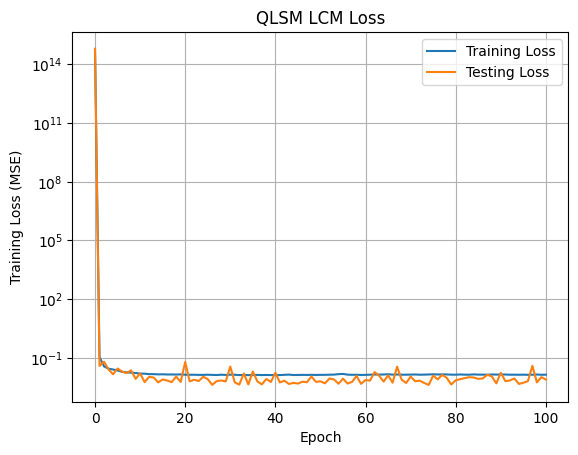

In [8]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:100]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'{lsm_design} LCM Loss')
_ = ax.legend()

In [9]:
losses.idxmin()

epoch          0
train_loss    34
test_loss     74
dtype: int64

# Building

## Model

In [10]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [11]:
torchinfo.summary(model, (1, 70), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QModel                                   [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    248
├─Linear: 1-2                            [1, 8]                    248
├─BatchNorm1d: 1-3                       [1, 26]                   52
├─Linear: 1-4                            [1, 32]                   864
├─ReLU: 1-5                              [1, 32]                   --
├─Dropout: 1-6                           [1, 32]                   --
├─Sequential: 1-7                        [1, 32]                   --
│    └─Linear: 2-1                       [1, 32]                   1,056
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   1,056
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 32]                   1,056
│  

# Utils

In [12]:
eval_util = LCMEvalUtil(config, model, gen)

In [13]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=4.67, T=28, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[])
System(E=8192, s=9.612142770750648e-09, B=16.0, N=465449909, H=10.026393974604431, phi=1.0)


(1.6640371372186646, 1.7146062850952148)

In [14]:
eval_util.gen_random_sample()

({'z0': 0.115,
  'z1': 0.0010000000000000009,
  'q': 0.27,
  'w': 0.614,
  'B': 16.0,
  's': 4.486833572529509e-08,
  'E': 4096,
  'H': 18.15404244764816,
  'N': 321459191,
  'h': 0.409,
  'T': 16,
  'Q': 10,
  'cost_lcm': 6.977856636047363,
  'cost_acm': 6.9487262956164635},
 LSMDesign(h=0.409, T=16, policy=<Policy.QFixed: 3>, Q=10, Y=1.0, Z=1.0, K=[]),
 System(E=4096, s=4.486833572529509e-08, B=16.0, N=321459191, H=18.15404244764816, phi=1.0))

## LCM Evaluation

In [15]:
num_samples = 10000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, z0, z1, q, w)
        bad.append((norm_delta, z0, z1, q, w, design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
1420,0.836,0.153,0.001,0.010,64.0,1.994627e-08,2048,14.733904,550482026,7.129,18,1,0.049789,0.194909,0.145121,0.744554
2466,0.655,0.111,0.005,0.229,128.0,5.233672e-09,1024,9.876145,812989856,8.965,8,1,0.076880,0.190237,0.113357,0.595871
424,0.796,0.033,0.004,0.167,64.0,5.156634e-08,2048,13.454723,367699020,12.291,3,1,0.058044,0.120340,0.062296,0.517664
4486,0.465,0.029,0.011,0.495,128.0,6.963447e-08,1024,14.831949,459093278,8.779,8,1,0.083995,0.145932,0.061936,0.424420
468,0.033,0.011,0.010,0.946,128.0,1.125317e-08,1024,5.775620,377685809,1.958,6,3,0.151667,0.241291,0.089624,0.371437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,0.175,0.073,0.005,0.747,64.0,9.810922e-08,2048,17.601751,788521908,14.336,11,5,0.318963,0.241759,-0.077204,-0.319344
8483,0.307,0.045,0.004,0.644,8.0,6.256176e-08,8192,15.125304,798934304,7.125,29,17,1.140266,0.861218,-0.279048,-0.324015
1408,0.308,0.201,0.003,0.488,32.0,3.918543e-08,4096,7.737311,158296682,6.485,21,18,1.098093,0.824383,-0.273710,-0.332017
9200,0.608,0.236,0.001,0.155,16.0,5.331011e-08,8192,16.602451,636549656,15.408,15,13,0.473459,0.353553,-0.119906,-0.339146


In [17]:
# cost, z0, z1, q, w, design, system = bad[0]
# z0, z1, q, w, design, system
# eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

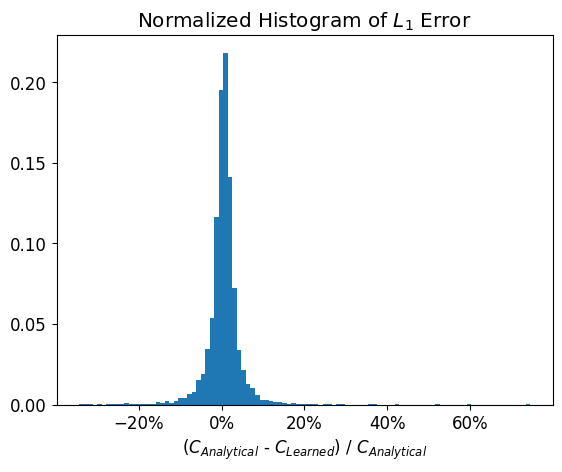

In [18]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [19]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 88.920%


In [20]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
7504,0.282,0.008,0.347,0.363,64.0,1.032860e-08,2048,19.941522,911977719,17.456,18,2,1.886387,1.796828,-0.089559,-0.049843
2477,0.850,0.035,0.050,0.065,4.0,5.838651e-08,8192,8.719953,162376541,8.332,19,17,3.648723,3.475652,-0.173071,-0.049795
1950,0.083,0.665,0.174,0.078,8.0,2.242626e-08,4096,9.197030,593707312,1.401,13,1,1.866592,1.778398,-0.088194,-0.049592
3243,0.124,0.052,0.613,0.211,64.0,7.390746e-08,1024,11.867635,349070744,8.855,13,1,1.881557,1.792680,-0.088878,-0.049578
1995,0.076,0.197,0.037,0.690,16.0,8.392113e-09,2048,17.102020,779463041,6.066,5,2,0.946184,0.901518,-0.044666,-0.049545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,0.003,0.794,0.040,0.163,32.0,8.453016e-08,2048,8.293408,524678027,1.504,16,14,5.031121,5.294600,0.263479,0.049764
3722,0.264,0.481,0.154,0.101,16.0,7.348671e-09,8192,9.442933,408531663,4.321,16,4,2.393985,2.519450,0.125465,0.049799
8093,0.054,0.474,0.153,0.319,32.0,4.096130e-08,1024,18.230342,518668122,2.213,10,5,2.498525,2.629485,0.130960,0.049805
817,0.219,0.524,0.012,0.245,128.0,9.984776e-08,1024,5.406096,420848680,1.271,9,8,3.514513,3.699164,0.184651,0.049917


In [21]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
8900,0.645,0.001,0.004,0.350,16.0,2.382981e-08,4096,11.360709,653804601,8.375,17,16,0.690666,0.513879,-0.176787,-0.344024
9200,0.608,0.236,0.001,0.155,16.0,5.331011e-08,8192,16.602451,636549656,15.408,15,13,0.473459,0.353553,-0.119906,-0.339146
1408,0.308,0.201,0.003,0.488,32.0,3.918543e-08,4096,7.737311,158296682,6.485,21,18,1.098093,0.824383,-0.273710,-0.332017
8483,0.307,0.045,0.004,0.644,8.0,6.256176e-08,8192,15.125304,798934304,7.125,29,17,1.140266,0.861218,-0.279048,-0.324015
1905,0.175,0.073,0.005,0.747,64.0,9.810922e-08,2048,17.601751,788521908,14.336,11,5,0.318963,0.241759,-0.077204,-0.319344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.033,0.011,0.010,0.946,128.0,1.125317e-08,1024,5.775620,377685809,1.958,6,3,0.151667,0.241291,0.089624,0.371437
4486,0.465,0.029,0.011,0.495,128.0,6.963447e-08,1024,14.831949,459093278,8.779,8,1,0.083995,0.145932,0.061936,0.424420
424,0.796,0.033,0.004,0.167,64.0,5.156634e-08,2048,13.454723,367699020,12.291,3,1,0.058044,0.120340,0.062296,0.517664
2466,0.655,0.111,0.005,0.229,128.0,5.233672e-09,1024,9.876145,812989856,8.965,8,1,0.076880,0.190237,0.113357,0.595871


In [22]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

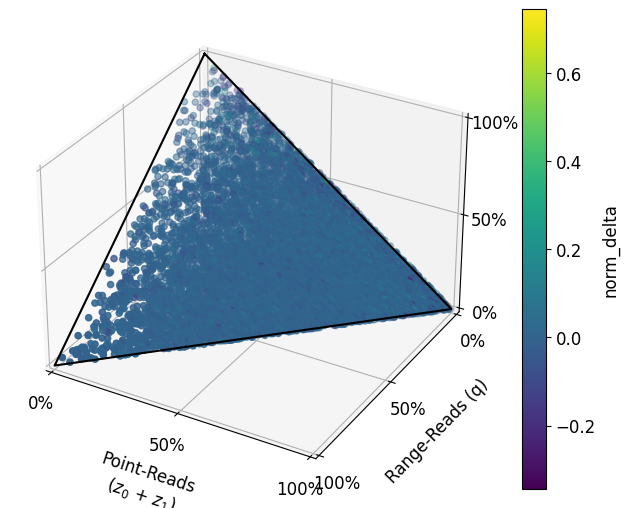

In [23]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

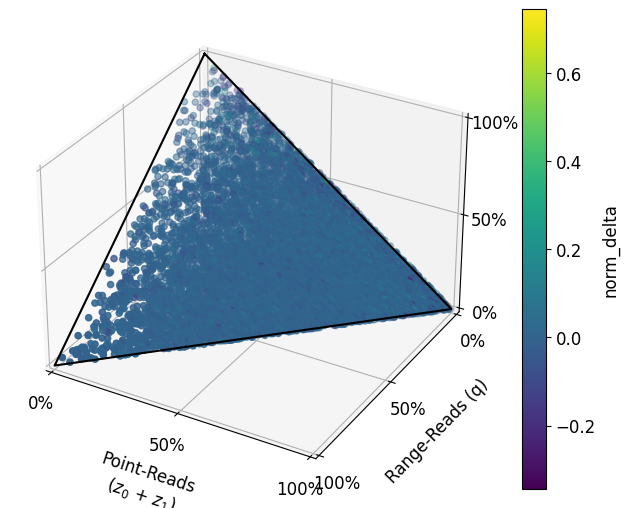

In [24]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 1) & (df.norm_delta > -1)], 'norm_delta')

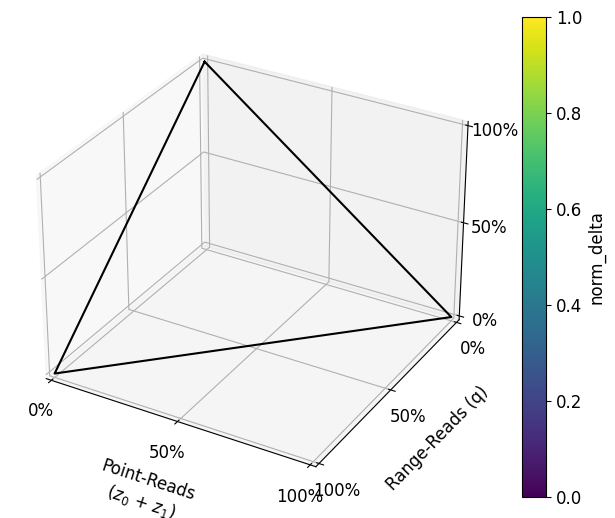

In [25]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 1) | (df.norm_delta < -1)], 'norm_delta')

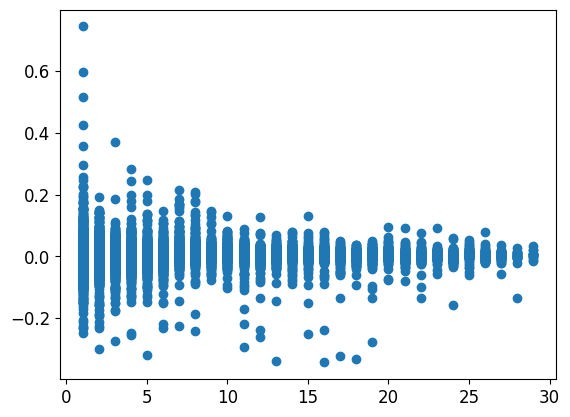

In [26]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['Q'], df.norm_delta)
None